### Import neccessary libraries 

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import RandomFlip, RandomRotation
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

#### Exploring and understanding the dataset

In [3]:
# Save the image size,batch_size, image channel and epoch
image_size = 256 
batch_size = 32 # One batch is 32 images 
channel = 3 # it is an RGB image
epoch = 50 # 50 complete pass through the entire trainning dataset when we do traning a model

#### Preprocesses the data set to do the modeling

In [4]:
# Loading the datsaet through keras preprocessing
data = tf.keras.preprocessing.image_dataset_from_directory(
    "potato_plant",
    shuffle = True,
    image_size = (image_size, image_size),
    batch_size = batch_size  
)

Found 2152 files belonging to 3 classes.


In [5]:
# How many 32 baches we have
len(data)

68

In [38]:
20% ---> test ---> devide it in to 10% validation and 10% test # DUring the trainning processes after each epoch we do validation using 10% then 
#we will do our final model then we will use the 10% dataset to measure the accuracy/performance of our model(before deploying the model).  
80% ---> trainning

In [25]:
# Let's find out how many sample is 80% of our dataset
train_ = 0.8
len(data) * train_ 

54.400000000000006

In [26]:
train_dataset = data.take(54) # Take first 54 sample of the dataset to train
len(train_dataset) # check howmany 

54

In [27]:
test_dataset = data.skip(54) # skips the first 54 and show the rest of the dataset 
len(test_dataset) # the rest 14 samples are our test dataset

14

In [28]:
val_size = 0.1
len(data) * val_size # Our validation dataset sample

6.800000000000001

In [29]:
val_dataset = test_dataset.take(6) 
len(val_dataset)  # we took 6 samples as our validation dataset 

6

In [30]:
# Track the tensor flow dataset and split 
def get_data_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000 ):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds 

In [31]:
# we will fit our dataset in to the above function and split train, test and validation 
train_ds, val_ds, test_ds = get_data_partitions_tf(data)

In [32]:
len(train_ds)

54

In [33]:
len(test_ds)

8

In [34]:
len(val_ds)

6

In [35]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

#### Cache, Shuffle and Prefetch the data

In [36]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size, image_size),
    layers.Rescaling(1.0/255)
])

#### Data Augmentaion

In [37]:
from tensorflow.keras.layers import RandomFlip, RandomRotation
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal_and_verical"),
  RandomRotation(0.2),
])

#### Data augmentation to train data

In [40]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

#### Model Architecture (CNN)

In [42]:
input_shape = (batch_size, image_size, image_size, channel)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [43]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

#### Compiling the model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [44]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [46]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.4798 - loss: 0.9318 - val_accuracy: 0.5052 - val_loss: 0.8533
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.5519 - loss: 0.8780 - val_accuracy: 0.7760 - val_loss: 0.5258
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.7711 - loss: 0.5742 - val_accuracy: 0.8021 - val_loss: 0.4198
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.8528 - loss: 0.3843 - val_accuracy: 0.8854 - val_loss: 0.2889
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.8990 - loss: 0.2675 - val_accuracy: 0.8854 - val_loss: 0.4420
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.8732 - loss: 0.3382 - val_accuracy: 0.7865 - val_loss: 0.4631
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.9043 - loss: 0.2419 - val_accuracy: 0.9219 - val_loss: 0.2025
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.9436 - loss: 0.1410 - val_accuracy: 0.8958 - v

In [47]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 627ms/step - accuracy: 0.9769 - loss: 0.0541


In [48]:
scores

[0.06629208475351334, 0.96875]

#### Ploting the accuracy and loss curves

In [49]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [50]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [51]:
type(history.history['loss'])

list

In [52]:
len(history.history['loss'])

50

In [53]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9020581245422363,
 0.7921509742736816,
 0.5494975447654724,
 0.3484193682670593,
 0.2964913547039032]

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

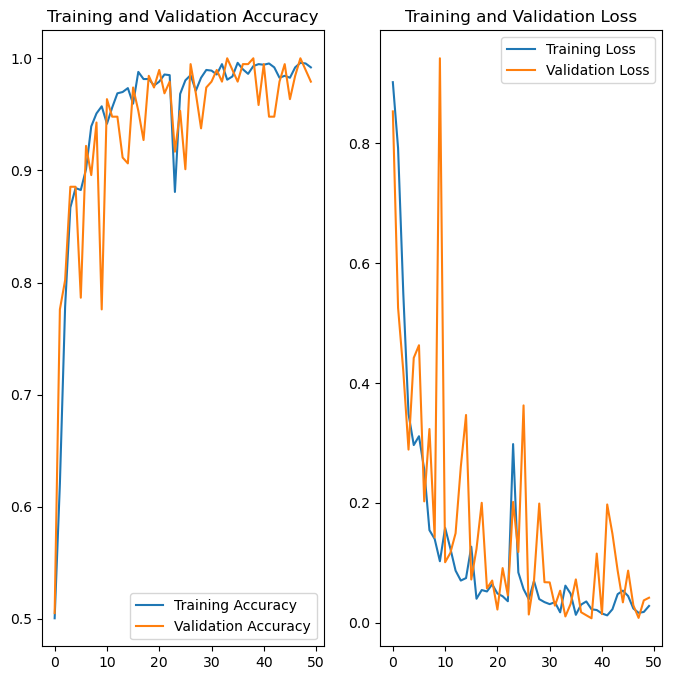

In [56]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epoch), acc, label='Training Accuracy')
plt.plot(range(epoch), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epoch), loss, label='Training Loss')
plt.plot(range(epoch), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### A single image prediction

first image to predict
actual label: Potato___Late_Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
predicted label: Potato___Late_Blight


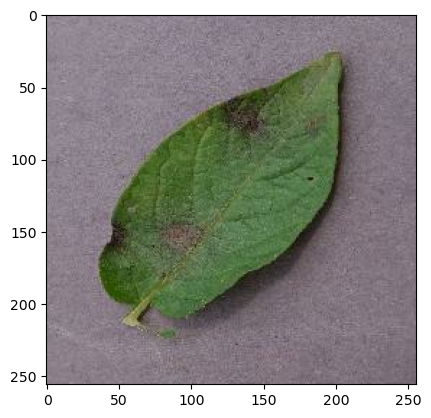

In [60]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",cl_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",cl_name[np.argmax(batch_prediction[0])])

#### Inference

In [65]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = cl_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

#### Try the inference on few sample images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


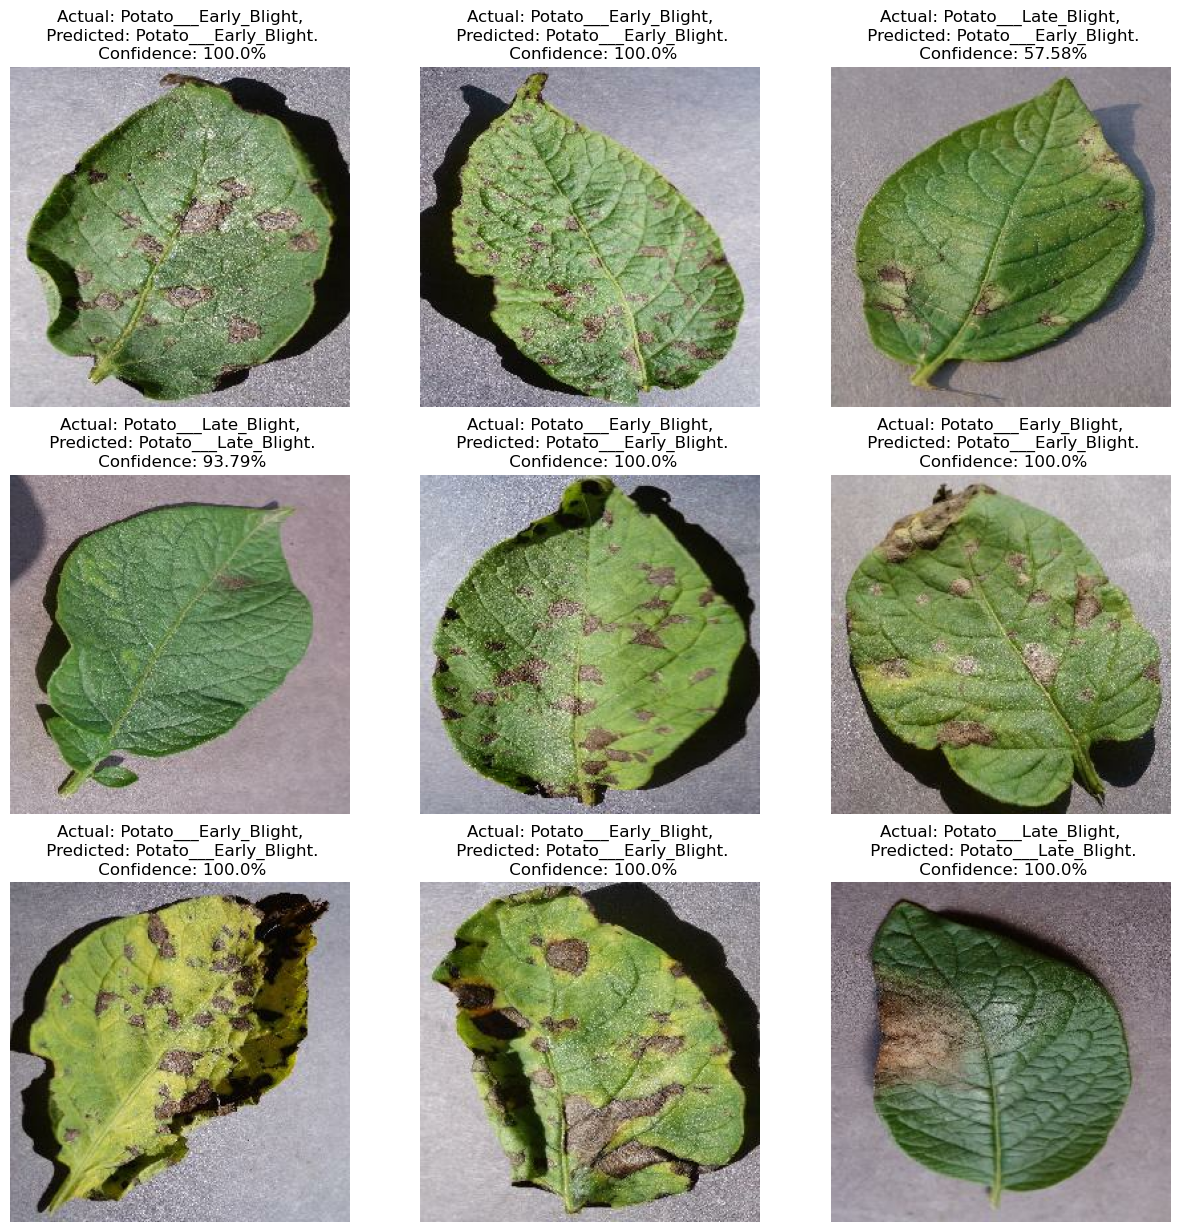

In [66]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = cl_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

 #### Save the model

In [90]:
#model.save("../models/1.keras") # Save as native Keras format

In [95]:
#model.save("../models/2.keras")

In [99]:
#model.save("../models/1.h5")  # Save as HDF5 format

In [98]:
#model.save("../models/2.h5")

In [97]:
#model.export("../models/1")  # Save as SavedModel format

In [96]:
#model.export("../models/2")  